In [2]:
import landsat_sample_functions as lf

In [3]:
import glob
import os
import re
import datetime
dexpr = re.compile("\d{4}[-/]\d{2}[-/]\d{2}")

In [4]:
rgbf = glob.glob('../data/landast_archibe/RGB_subset_*')
rthermrad = glob.glob('../data/landast_archibe/landsat_thermrad_*')
rflect = glob.glob('../data/landast_archibe/landsat_reflectances_*')
latlon = glob.glob('../data/landast_archibe/landsat_latlon_*')


In [5]:
def unpack(filename):
    _, fullname = os.path.split(filename)
    name, ext = os.path.splitext(fullname)
    date = dexpr.findall(name)[0]
    dt = datetime.datetime.strptime(date, '%Y-%m-%d')
    if ext == '.txt':
        data = lf.landsat_read(filename)
    return (dt, data)

In [6]:
def up(files):
    return [unpack(fn) for fn in sorted(files)]
    

In [7]:
data = dict()
for f, k in [(rthermrad, "thermrad"), (rflect, "reflectances"), (latlon,"latlon")]:
    data[k] = up(f)


In [8]:
import xarray as xr
import numpy as np

In [9]:
dv = [np.stack(zip(*data[k])[-1]) for k in ['thermrad', 'reflectances']]
    

In [10]:
landsat = np.concatenate( [dv[1], dv[0][...,np.newaxis]], axis=-1)

In [11]:
landsat.shape

(21, 815, 921, 6)

In [12]:
layers  = ['NIR', 'Red', 'Green', 'Blue', 'UV', "Thermal Radiances"]

In [13]:
times, latlon = zip(*data['latlon'])

In [14]:
locs = np.stack(latlon)

In [15]:
lats = locs[...,0]
lons = locs[...,1]

In [16]:
lats.shape

(21, 815, 921)

In [30]:
import pandas as pd
coords = {'lon':(['time','y', 'x'], lons),
          'lat':(['time','y', 'x'], lats) ,
          'time':pd.to_datetime([t.date() for t in times])}

In [31]:
data = dict()
for l, d in zip(layers, landsat.transpose([-1,0, 1,2])):
    print(l, d.shape)
    data[l] = (['time','y', 'x'], d[:, ::-1, :])

('NIR', (21, 815, 921))
('Red', (21, 815, 921))
('Green', (21, 815, 921))
('Blue', (21, 815, 921))
('UV', (21, 815, 921))
('Thermal Radiances', (21, 815, 921))


In [32]:
ds = xr.Dataset(data, coords=coords)

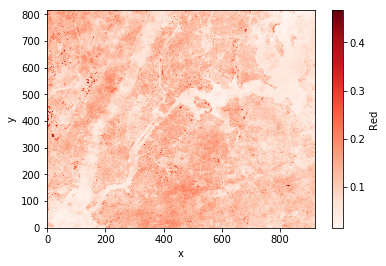

In [33]:
%matplotlib inline
ds['Red'].mean('time').plot(cmap='Reds')

In [35]:
ds.to_netcdf('landsat_hires.nc')

In [36]:
ds

<xarray.Dataset>
Dimensions:            (time: 21, x: 921, y: 815)
Coordinates:
    lat                (time, y, x) float64 40.88 40.88 40.88 40.88 40.88 ...
    lon                (time, y, x) float64 -74.07 -74.07 -74.07 -74.06 ...
  * time               (time) datetime64[ns] 2014-04-10 2014-04-26 ...
Dimensions without coordinates: x, y
Data variables:
    Blue               (time, y, x) float64 0.0991 0.0868 0.0807 0.0784 ...
    Thermal Radiances  (time, y, x) float64 8.023 7.835 7.669 7.523 7.41 ...
    UV                 (time, y, x) float64 0.1126 0.1031 0.0981 0.0957 ...
    Green              (time, y, x) float64 0.0774 0.0633 0.0564 0.0533 ...
    NIR                (time, y, x) float64 0.0529 0.0 0.0 0.0 0.0 0.0 0.0 ...
    Red                (time, y, x) float64 0.0694 0.0424 0.0278 0.0234 ...